In [224]:
### THIS PROJECT USES TENSORFLOW=2.15 AND KERAS=3.0.5

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np

In [2]:
face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#### Testing

In [193]:
cap=cv2.VideoCapture(0)
while True:
    ret,frame=cap.read()
    if ret:
        # cv2.rectangle(frame,(140,50),(500,400),(0,0,255),2)
        gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3)
        # a=0,b=0,c=0,d=0
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
            # a=x,b=y,c=w,d=h
        cv2.imshow("test",frame[140:500,50:400])
        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
cap.release()
cv2.destroyAllWindows()


In [190]:
cap.release()

### Data Augmentation

In [392]:
for img in os.listdir("images"):
    image=cv2.imread(os.path.join("images",img))
    name=img
    new_img=tf.image.stateless_random_flip_up_down(image,seed=(np.random.randint(100),np.random.randint(100)))
    new_img = tf.image.stateless_random_flip_left_right(new_img, seed=(np.random.randint(100),np.random.randint(100)))
    new_img = tf.image.stateless_random_brightness(new_img, max_delta=0.02, seed=(1,2))
    new_img = tf.image.stateless_random_contrast(new_img, lower=0.6, upper=1, seed=(1,3))
    new_img = tf.image.stateless_random_jpeg_quality(new_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
    new_img = tf.image.stateless_random_saturation(new_img, lower=0.9, upper=1, seed=(np.random.randint(100),np.random.randint(100))) 
    cv2.imwrite(os.path.join("images",name),new_img.numpy())

In [204]:
#creating tf data pipeline
positives=tf.data.Dataset.from_tensor_slices(tf.io.gfile.glob("images/*.jpg")[:5600])

In [205]:
len(positives)

5600

In [239]:
negatives=tf.data.Dataset.from_tensor_slices(tf.io.gfile.glob("images/no face/*.jpg")[:4000])

In [208]:
negatives.as_numpy_iterator().next()

b'images\\no face\\airplane_0000.jpg'

In [209]:
len(negatives)

5600

In [240]:
positive=tf.data.Dataset.zip((positives,tf.data.Dataset.from_tensor_slices(tf.ones(len(positives)))))
negative=tf.data.Dataset.zip((negatives,tf.data.Dataset.from_tensor_slices(tf.zeros(len(negatives)))))

In [211]:
positive,negative.element_spec

(<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>,
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.float32, name=None)))

In [241]:
len(positive),len(negative)

(5600, 4000)

In [3]:
#preprocessing image
def load_image(x):
    byte_image=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_image,channels=3)
    img=tf.image.resize(img,(200,200))
    img=img/255.0
    return img

In [242]:
data=positive.concatenate(negative)

In [215]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [216]:
sample=data.as_numpy_iterator().next()

In [217]:
sample

(b'images\\Aaron_Eckhart_0001.jpg', 1.0)

In [4]:
def preprocess(image,label):
    return(load_image(image),label)

In [219]:
res=preprocess(*sample)

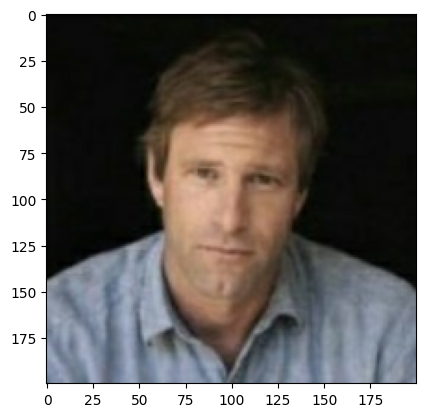

In [220]:
import matplotlib.pyplot as plt
plt.imshow(res[0])

In [243]:
#build dataloader pipeline
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=15000)

In [244]:
train=data.take(round(len(data)*.7))
train=train.batch(8)
train=train.prefetch(4)

In [245]:
val=data.skip(round(len(data)*.7))
val=val.take(round(len(data)*.3))
val=val.batch(8)
val=val.prefetch(4)

In [246]:
len(train),len(val)

(840, 360)

In [247]:
print(train.element_spec,val.element_spec)

(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)) (TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


### building Feature Extractor model

In [5]:
from tensorflow.keras.layers import Conv2D,Layer,Input,Dense,MaxPooling2D,Flatten,Concatenate,Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

In [229]:
def FeatureExtractor():
    i=Input(shape=(200,200,3))
    c1=Conv2D(64,kernel_size=(5,5),strides=(2,2),activation="relu",name="first_conv")(i)
    m1=MaxPooling2D(pool_size=(2,2),strides=(1,1),padding="same")(c1)
    
    c2=Conv2D(32,kernel_size=(3,3),strides=(2,2),activation="relu",name="second_conv")(m1)
    m2=MaxPooling2D(pool_size=(5,5),strides=(2,2),padding="same")(c2)
    
    c3=Conv2D(128,kernel_size=(5,5),strides=(2,2),activation="relu",name="third_conv")(m2)
    
    f=Flatten()(c3)
    
    x=Dense(16,activation='relu',name="img_features",kernel_regularizer=L2())(f)

    return [i,x,c3]

In [16]:
def EuclideanDistance(feature1,feature2):
    return np.linalg.norm(feature1-feature2)

In [231]:
def addLastLayer():
    i,fully_connected,c4=FeatureExtractor()
    x=Dense(1,activation="sigmoid")(fully_connected)
    final_model=Model(inputs=[i],outputs=[x,c4])
    final_model.build(input_shape=(200,200,3))
    return final_model

In [232]:
final_model=addLastLayer()

In [233]:
final_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_conv (Conv2D)                  │ (None, 98, 98, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_conv (Conv2D)                 │ (None, 48, 48, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_conv (Conv2D)                  │ (None, 10, 10, 128)         │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ img_features (Dense)                 │ (None, 16)                  │         204,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,689 (1.26 MB)

 Trainable params: 330,689 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [234]:
loss=tf.keras.losses.binary_crossentropy
accuracy=tf.keras.metrics.BinaryAccuracy(name="accuracy")
opt=tf.keras.optimizers.Adam(learning_rate=3e-6)

In [6]:
class Attendance(Model):
    def __init__(self,model,**kwargs):
        super().__init__(**kwargs)
        self.model=model
        
    def compile(self,opt,loss,metric,**kwargs):
        super().compile(**kwargs)
        self.loss=loss
        self.opt=opt
        self.metric=metric
    
    def train_step(self,batch,**kwargs):
        X,y=batch
        y=tf.expand_dims(y, axis=-1)
        
        with tf.GradientTape() as tape:
            y_pred=self.model(X,training=True)
            classLoss=self.loss(y,y_pred[0])
            grad=tape.gradient(classLoss,self.model.trainable_variables)
        opt.apply_gradients(zip(grad,self.model.trainable_variables))
        
        acc=accuracy(y,y_pred[0])
        return {"loss":classLoss,"accuracy":acc}
    
    def test_step(self,batch,**kwargs):
        X,y=batch
        y=tf.expand_dims(y, axis=-1)
        y_pred=self.model(X,training=False)
        vaLoss=self.loss(y,y_pred[0])
        self.metric.update_state(y, y_pred[0])
        return {"loss":vaLoss,"accuracy":self.metric.result()}
    
    def get_config(self):
        base_config = super().get_config()
        config = {
                "submodel": tf.keras.utils.serialize_keras_object(self.model),
                }
        return {**base_config, **config}
    
    @classmethod
    def from_config(cls, config):
        submodel_config = config.pop("submodel")
        submodel = tf.keras.utils.deserialize_keras_object(submodel_config)
        return cls(model=submodel, **config)
    
    def call(self,X,**kwargs):
        return self.model(X,**kwargs)

In [236]:
model=Attendance(final_model)

In [237]:
model.compile(opt=opt,loss=loss,metric=accuracy)

In [ ]:
hist=model.fit(train,epochs=5,validation_data=val)

In [ ]:
model.predict(test_img)

In [91]:
# model.save("AttendanceSystem.keras")
# model.save_weights("model_weights.h5")

In [7]:
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'Attendance': Attendance}):
    # custom_objects = {'Attendance': Attendance.from_config}
    # custom_objects={'Functional':tf.keras.models.Model}
    model=tf.keras.models.load_model("AttendanceSystem.keras")

C:\Users\dellb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


### Manual Testing

In [97]:
test_img=os.path.join("images","Zinedine_Zidane_0001.jpg")
# test_img=os.path.join("D:\downloads\IMG_20220113_172032 (1) (2022_07_10 07_51_22 UTC).jpg")

In [98]:
test_img

'images\\Zinedine_Zidane_0001.jpg'

In [99]:
test_img=load_image(test_img)

In [100]:
test_img=np.expand_dims(test_img,axis=0)

In [101]:
# test_img

In [102]:
feature1=model.predict(test_img)[1]
# feature1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [103]:
feature2=model.predict(np.expand_dims(load_image(os.path.join("images","Zydrunas_Ilgauskas_0001.jpg")),axis=0))[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [104]:
dist1=EuclideanDistance(feature1,feature2)

In [105]:
dist2=EuclideanDistance(feature1,model.predict(np.expand_dims(load_image(os.path.join("images","Zinedine_Zidane_0004.jpg")),axis=0))[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [106]:
dist1,dist2

(33.506245, 20.475414)

In [107]:
dist2<dist1

True

In [108]:
person_feature={}

In [109]:
for peeps in ['Zinedine_Zidane_0002', 'Zydrunas_Ilgauskas_0001', 'Zoe_Ball_0001', 'Zico_0001', 'Yuri_Malenchenko_0002', 'Zoran_Djindjic_0003']:
    person_feature[peeps]=EuclideanDistance(feature1,model.predict(np.expand_dims(load_image(os.path.join("images",peeps+".jpg")),axis=0))[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [110]:
len(person_feature)

6

In [111]:
min_distance=min(person_feature.values())

In [112]:
min_distance

18.302929

In [113]:
person_feature.values()

dict_values([20.943531, 33.506245, 22.714153, 18.302929, 27.190762, 25.865902])

In [87]:
for key in list(person_feature.keys()):
    if person_feature[key]==min_distance:
        print(key)
        break

Zinedine_Zidane_0002


In [88]:
person_feature.keys()

dict_keys(['Zinedine_Zidane_0002', 'Zydrunas_Ilgauskas_0001', 'Zoe_Ball_0001', 'Zico_0001', 'Yuri_Malenchenko_0002', 'Zoran_Djindjic_0003'])

### Realtime Comparison

In [8]:
def isFace(gray,frame):
    faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3)
    if len(faces)>0:
        return (True,faces)
    else:
        return(False,faces)

In [9]:
def NewFace():
    cap=cv2.VideoCapture(0)
    try:
        while True:
            ret,frame=cap.read()
            if ret:
                # cv2.rectangle(frame,(140,50),(500,400),(0,0,255),2)
                gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                face,coord=isFace(gray,frame)
                # print(coord)
                if face:
                    for (x,y,w,h) in coord:
                        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                cv2.imshow("test",frame)
                key=cv2.waitKey(1) & 0xFF
                if face and key==ord('c'):
                    name=input("Enter name: ")
                    print("processing..")
                    imgpath=os.path.join("user_imgs",name+".jpg")
                    cv2.imwrite(imgpath,frame[coord[0][1]:coord[0][1]+coord[0][3],coord[0][0]:coord[0][0]+coord[0][2]])
                    frame=np.expand_dims(load_image(imgpath),axis=0)
                    features=model.predict(frame)
                    print(features[0])
                    np.save("features/"+name+".npy",features[1])
                    print("done")
                    cap.release()
                    cv2.destroyAllWindows()
                    return
                elif key==ord('q'):
                    break
    except Exception as e:
        print(e,frame.shape)
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
NewFace()

In [118]:
feature_test=np.load("features/arnav.npy")

In [124]:
# print(feature_test)

In [ ]:
np.load("features/deepak.npy")

In [17]:
def SameFaceCheck():
    cap=cv2.VideoCapture(0)
    try:
        while True:
            ret,frame=cap.read()
            if ret:
                gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                face,coord=isFace(gray,frame)
                if face:
                    for (x,y,w,h) in coord:
                        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                cv2.imshow("test",frame)
                key=cv2.waitKey(1) & 0xFF
                if face and key==ord('a'):
                    print("processing..")
                    imgpath=os.path.join("user_imgs","temp"+".jpg")
                    cv2.imwrite(imgpath,frame[coord[0][1]:coord[0][1]+coord[0][3],coord[0][0]:coord[0][0]+coord[0][2]])
                    img=np.expand_dims(load_image(imgpath),axis=0)
                    new=model.predict(img)[1]
                    person_feature={}
                    for feature in os.listdir("features"):
                        present=np.load("features/"+feature)
                        # distance=L1Distance(present,new)
                        distance=EuclideanDistance(present,new)
                        person_feature[distance]=feature
                    min_dist=min(person_feature.keys())
                    print(person_feature[min_dist][:-4])
                    os.remove(os.path.join("user_imgs","temp.jpg"))
                    cap.release()
                    cv2.destroyAllWindows()
                    return
                elif key==ord('q'):
                    break
    except Exception as e:
        print(e)
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
SameFaceCheck()